# Speedtesting Chemical Fingerprints

Chemical fingerprints are a method of representing chemical compounds as bit vectors. As such, they are extremely useful for machine learning approaches to cheminformatics and drug discovery. Many fingerprinting methods have been investigated and published, with pros and cons which I'm looking forward to discussing in another blog. However, the purpose of article is a simple speedtest to determine the most efficient fingerprinting method. Benchmarking this was inspired by a recent pre-processing step in a current project where we needed to represent a dataset of over 2 million ligands as fingerprints; obviously here, speed was a key consideration. In the end, we pivoted from a fingerprinting approach to a scaffolding approach to examine molecule substructures. This doubled as a performance increase, and an easy way to group similar molecules without having to think about avoid an exhaustive (and unfeasible) $2,000,000^2$ similarity comparison.

### Fingerprinting Options

In this benchmark we're just going to look at the options provided by the fantastic open-source cheminformatics tool RDKit. From the documentation, they offer 7 different built-in fingerprinting approaches:

|Fingerprint|
|-----------|
|RDKit|
|Atom Pairs|
|Topological Torsions|
|MACCS keys|
|Morgan/Circular|
|Pattern|
|Extended Reduced Graphs|

# Benchmark dataset

To get a fair estimate of the speed of generating these fingerprints, we need a dataset of small molecule compounds to use as a benchmark. In this case, we downloaded the ChEMBL database (2,136,187 molecules) and sampled 5000 molecules using the following python code:

In [4]:
import time
import random
from rdkit import Chem

benchmark_molecules = list()

# load the molecules as a generator object
chembl_mols = Chem.SDMolSupplier('chembl_30.sdf')

# sample 5000 random molecules with a constant seed for reproducibility
random.seed(42)

total_molecules = 2136187

benchmark_set_indexes = random.sample(range(1, total_molecules), 5000)

for index in benchmark_set_indexes:
    benchmark_molecules.append(chembl_mols[index])

Then for each fingerprint, we can time three runs of fingerprinting this benchmark set:

In [39]:
def time_fingerprint(fingerprint, radius):
    seconds = list()
    for i in range(3):
        start = time.time()
        if radius is None:
            fingerprints = [fingerprint(mol) for mol in benchmark_molecules]
        else:
            fingerprints = [fingerprint(mol, radius) for mol in benchmark_molecules]
        end = time.time()
        run_time = end - start
        seconds.append(run_time)
    return seconds

times = dict()

#### RDKit Fingerprints:

In [40]:
times['RDKit'] = time_fingerprint(Chem.RDKFingerprint, None)

#### Atom Pair Fingerprints:

In [41]:
from rdkit.Chem.AtomPairs import Pairs
times['AtomPair']= time_fingerprint(Pairs.GetAtomPairFingerprint, None)

#### Topological Torsion Fingerprints:

In [42]:
from rdkit.Chem.AtomPairs import Torsions
times['Torsions'] = time_fingerprint(Torsions.GetTopologicalTorsionFingerprintAsIntVect, None)

#### Morgan Fingerprints:

In [43]:
from rdkit.Chem import AllChem
times['Morgan'] = time_fingerprint(AllChem.GetMorganFingerprint, 2)

#### MACCS Fingerprints:

In [48]:
from rdkit.Chem import MACCSkeys
times['MACCS'] = time_fingerprint(MACCSkeys.GenMACCSKeys, None)

#### ErG Fingerprints:

In [50]:
from rdkit.Chem import rdReducedGraphs
times['ERG'] = time_fingerprint(rdReducedGraphs.GetErGFingerprint, None)

#### Pattern Fingerprints:

In [51]:
from rdkit.Chem import rdmolops
times['Pattern'] = time_fingerprint(rdmolops.PatternFingerprint, None)

So let's see how they all compare:

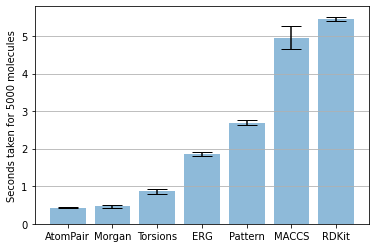

In [95]:
import numpy as np
import matplotlib.pyplot as plt

arrays = [np.asarray(v) for v in times.values()]
means = [np.mean(a) for a in arrays]
s_means = np.sort(means)
sort_indexes = [np.where(mean == means)[0][0] for mean in s_means]
stds = [np.std(arrays[i]) for i in sort_indexes]
labels = [list(times.keys())[i] for i in sort_indexes]

fig, ax = plt.subplots()
ax.bar(x_pos, s_means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Seconds taken for 5000 molecules')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.yaxis.grid(True)

# Save the figure and show
plt.savefig('fingerprint_benchmark.png', dpi=400)